In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_columns', None)

**Log condor metrics with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
attributes="ClusterId,ProcId,ExitStatus,JobStatus,LastJobStatus,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,JobRunCount,RequestMemory,JobStartDate,MATCH_EXP_JOBGLIDEIN_ResourceName,User,Owner,ResidentSetSize_RAW,CumulativeRemoteUserCpu,BytesRecvd,RemoteWallClockTime,NumJobStarts,BytesSent,ExecutableSize_RAW,CumulativeSlotTime,ExitCode,CompletionDate,TransferInputSizeMB,RemoteUserCpu,RequestDisk,RequestCpus,DiskUsage_RAW"
timestamp=$(date +%F_%T_%s | sed -s 's/[-:]//g')
for uafnum in 4 8 10; do
    fname="logs/history_uaf${uafnum}_${timestamp}.txt.gz"
    echo "Writing to $fname"
    earlier=$(($(date +%s) - 6*3600)) # 6 hours
    condor_history -name uaf-${uafnum}.t2.ucsd.edu -since "CompletionDate<${earlier}"  -json -attributes  ${attributes} | gzip -9 > $fname
done
```

In [2]:
def get_condor_df():
    """
    Each gzipped file is just a list of jsons for job classads
    which were taken from condor_history every 6 hours.
    Cache the output in a pickle file
    """
    pkl_fname = "data/df_condor.pkl.bz2"
    if os.path.exists(pkl_fname):
        return pd.read_pickle(pkl_fname)
    fnames = glob.glob("condor/logs/*.gz")
    dfs = []
    for fname in tqdm(fnames):
        try: df = pd.read_json(fname)
        except: continue
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    df.to_pickle(pkl_fname)
    return df

**Log hadoop metrics with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
fname="logs/nodes_$(date +%F_%T_%s | sed -s 's/[-:]//g').txt"
echo "Writing to $fname"
echo "Getting hadoop info"
hdfs fsck -locations -blocks -files /cms/store/group/snt/run2_data2018/MET_Run2018D-PromptReco-v2_MINIAOD_CMS4_V10-02-04/ > $fname
echo "Parsing hadoop info to get unique node IPs"
ips=$(grep -oE '[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}:' ${fname} | cut -d ':' -f1 | sort | uniq)
echo "Found $(echo $ips | wc -w) unique node IPs"
echo >> $fname
echo "-------- BEGIN DNS LOOKUP --------" >> $fname
for ip in ${ips} ; do h=$(host -W 1 $ip); echo $ip $h ; done >> $fname
echo "-------- END DNS LOOKUP --------" >> $fname
```

In [3]:
def get_hadoop_df():
    """
    Each text file has the output of hadoop fsck as well as a DNS/hostname lookup on the node IPs.
    Cache the output in a pickle file.
    """
    pkl_fname = "data/df_hadoop.pkl"
    if os.path.exists(pkl_fname):
        return pd.read_pickle(pkl_fname)
    fnames = glob.glob("hadoop/logs/*.txt")
    data = []
    # Strip out t2 suffix
    def parse_dns(x):
        return x.split()[-1][:-1].replace(".t2.ucsd.edu","")
    for fname in fnames:
        dnslines = []
        nodes = None
        in_dns = False
        for line in open(fname,"r"):
            if line.startswith(" Number of data-nodes"): nodes = int(line.split()[-1])
            elif line.startswith("-------- BEGIN DNS LOOKUP"): in_dns = True
            elif line.startswith("-------- END DNS LOOKUP"): in_dns = False
            elif in_dns and "BEGIN" not in line: dnslines.append(line)
        hosts = set(map(parse_dns,dnslines))
        timestamp = int(fname.rsplit("_",1)[1].rsplit(".",1)[0])
        data.append(dict(timestamp=timestamp,hosts=hosts,nodes=nodes))
    df = pd.DataFrame(data)
    df = df.sort_values("timestamp",ascending=True).reset_index()
    # Pairwise set subtractions to get hosts that were added or lost
    df["hosts_gained"] = pd.Series([set()]+map(lambda x:x[0]-x[1], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["hosts_lost"] = pd.Series([set()]+map(lambda x:x[1]-x[0], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["nhosts_gained"] = df.hosts_gained.map(len)
    df["nhosts_lost"] = df.hosts_lost.map(len)
    df["nhosts"] = df.hosts.map(len)
    df["date"] = pd.to_datetime(df["timestamp"],unit="s")
    df = df.drop(["hosts","timestamp"],axis=1)
    df.to_pickle(pkl_fname)
    return df

In [4]:
df_condor = get_condor_df()
df_hadoop = get_hadoop_df()

In [5]:
# Historical job ClassAd information
df_condor.head()

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,MATCH_EXP_JOBGLIDEIN_ResourceName,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,User
0,0,55837204.0,89595.0,9873627,1555376527,1390,1437,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-4-4-32.t2.ucsd.edu,UCSD,1,bemarsh,354,1390,1437,1,5242880,1024,673072.0,53,bemarsh@t2.ucsd.edu
1,1,55837204.0,89505.0,9873627,1555376503,1359,1419,132782,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_2@cabinet-5-5-18.t2.ucsd.edu,UCSD,1,bemarsh,240,1359,1419,1,5242880,1024,738712.0,53,bemarsh@t2.ucsd.edu
2,2,55837204.0,89555.0,9873627,1555376474,1326,1393,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-1-1-15.t2.ucsd.edu,UCSD,1,bemarsh,193,1326,1393,1,5242880,1024,727556.0,53,bemarsh@t2.ucsd.edu
3,3,55837204.0,89518.0,9873627,1555376445,1310,1367,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-7-7-2.t2.ucsd.edu,UCSD,1,bemarsh,150,1310,1367,1,5242880,1024,657492.0,53,bemarsh@t2.ucsd.edu
4,4,55837204.0,89618.0,9873627,1555376437,577,645,135136,5,0.0,0,1.0,1.555376e+09,4,2,UCSDT2,slot1_1@sdsc-26.t2.ucsd.edu,UCSD,1,bemarsh,618,577,645,1,5242880,1024,731908.0,53,bemarsh@t2.ucsd.edu


In [6]:
# Information about hadoop node count and sets of gained/lost hosts
# Data is collected in 6 hour intervals
df_hadoop.tail()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date
137,15,186,{},{},0,0,185,2019-04-29 07:01:01
138,78,185,{},{cabinet-7-7-2},0,1,184,2019-04-29 13:01:01
139,128,185,{},{},0,0,184,2019-04-29 19:01:01
140,12,184,{cabinet-7-7-2},"{cabinet-2-2-2, cabinet-2-2-0}",1,2,183,2019-04-29 20:42:50
141,52,183,{},{cabinet-7-7-2},0,1,182,2019-04-30 00:03:00


In [7]:
# if we scraped too often, we might have double counted, so drop duplicates
df_condor = df_condor[~df_condor.duplicated(["ClusterId","ProcId"],keep="first")]

In [8]:
# Add another column to the hadoop DF which is just the datetime of the previous row (for convenience)
df_hadoop["prev_date"] = df_hadoop.date.shift(1)

In [9]:
# Convert unix timestamps into nice datetime objects
df_condor["CompletionDate"] = pd.to_datetime(df_condor["CompletionDate"],unit="s")
df_condor["JobStartDate"] = pd.to_datetime(df_condor["JobStartDate"],unit="s")

# Prettier aliases for long classad names
df_condor["site"] = df_condor["MATCH_GLIDEIN_Site"]
df_condor["slot"] = df_condor["MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot"]

# slot1_1@cabinet-4-4-32.t2.ucsd.edu -> cabinet-4-4-32
df_condor["host"] = df_condor["slot"].str.split("@").str[-1].str.replace(".t2.ucsd.edu","")

# blah@t2.ucsd.edu -> blah
df_condor["user"] = df_condor["User"].str.replace("@t2.ucsd.edu","")

# Fraction of CPU (CPU secs / Wall clock / # of CPUs requested for job)
# So fcpu = 1 means the job had 100% cpu usage on 1 core and the user requested 1 core
# fcpu > 1 means user should be requesting more CPUs ;)
df_condor["fcpu"] = df_condor["RemoteUserCpu"]/df_condor["RemoteWallClockTime"]/df_condor["RequestCpus"]

# Disk and memory usage in GB
df_condor["diskGB"] = df_condor["DiskUsage_RAW"]/1.0e6
df_condor["memGB"] = df_condor["ResidentSetSize_RAW"]/1.0e6

# Drop ugly classads
df_condor = df_condor.drop([
    "MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot",
    "MATCH_GLIDEIN_Site",
    "MATCH_EXP_JOBGLIDEIN_ResourceName",
    "User",
],axis=1)

# Only consider jobs running at UCSD that actually started running (mem usage != 0)
df_condor = df_condor[(df_condor.site.eq("UCSD")) & ~(df_condor["ResidentSetSize_RAW"]==0.)]

In [10]:
df_condor.tail()

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
453783,2121,27500276.0,60296.0,9807532,2019-03-26 20:37:26,187,611,107940,3,0.0,0,1.0,2019-03-26 20:27:15,4,2,1,dpgilber,233,187,611,1,5242880,1024,181324.0,26,UCSD,slot1_2@cabinet-4-4-21.t2.ucsd.edu,cabinet-4-4-21,dpgilber,0.306056,0.107940,0.181324
453784,2122,27498956.0,59517.0,9807532,2019-03-26 20:37:24,82,545,106003,3,0.0,0,1.0,2019-03-26 20:28:19,4,2,1,dpgilber,344,82,545,1,5242880,1024,2720.0,26,UCSD,slot1_4@cabinet-0-0-27.t2.ucsd.edu,cabinet-0-0-27,dpgilber,0.150459,0.106003,0.002720
453785,2123,27497924.0,60507.0,9807532,2019-03-26 20:37:24,48,482,105990,3,0.0,0,1.0,2019-03-26 20:29:22,4,2,1,dpgilber,436,48,482,1,5242880,1024,3580.0,26,UCSD,slot1_5@cabinet-11-11-10.t2.ucsd.edu,cabinet-11-11-10,dpgilber,0.099585,0.105990,0.003580
453786,2124,27503048.0,57047.0,9807532,2019-03-26 20:37:20,0,407,106050,3,0.0,0,1.0,2019-03-26 20:30:33,4,2,1,dpgilber,504,0,407,1,5242880,1024,3076.0,26,UCSD,slot1_4@cabinet-0-0-27.t2.ucsd.edu,cabinet-0-0-27,dpgilber,0.000000,0.106050,0.003076
453787,2125,283324160.0,72214.0,9806145,2019-03-26 20:37:18,12923,10524,2369278,3,0.0,0,1.0,2019-03-26 17:41:54,4,2,1,sjmay,1459,12923,10524,1,5242880,1024,1721700.0,270,UCSD,slot1_1@sdsc-38.t2.ucsd.edu,sdsc-38,sjmay,1.227955,2.369278,1.721700


In [11]:
df_hadoop.tail()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date
137,15,186,{},{},0,0,185,2019-04-29 07:01:01,2019-04-29 01:01:01
138,78,185,{},{cabinet-7-7-2},0,1,184,2019-04-29 13:01:01,2019-04-29 07:01:01
139,128,185,{},{},0,0,184,2019-04-29 19:01:01,2019-04-29 13:01:01
140,12,184,{cabinet-7-7-2},"{cabinet-2-2-2, cabinet-2-2-0}",1,2,183,2019-04-29 20:42:50,2019-04-29 19:01:01
141,52,183,{},{cabinet-7-7-2},0,1,182,2019-04-30 00:03:00,2019-04-29 20:42:50


**If the plot below were a flat line, I wouldn't even have made this notebook**

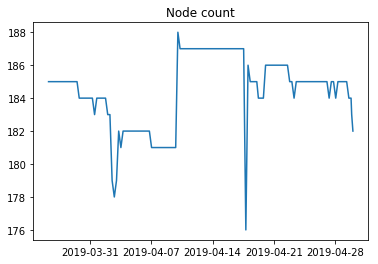

In [12]:
plt.plot(df_hadoop.date,df_hadoop.nhosts)
plt.title("Node count");

In [13]:
# Find intervals of 6 hrs where we gained 0 hosts wrt the previous interval, but lost exactly 1
badrows = df_hadoop.query("nhosts_gained==0 and nhosts_lost==1")
badrows

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date
14,102,185,{},{cabinet-0-0-17},0,1,184,2019-03-29 19:01:01,2019-03-29 13:01:01
21,48,184,{},{cabinet-7-7-0},0,1,183,2019-03-31 13:01:01,2019-03-31 07:01:01
27,104,184,{},{cabinet-4-4-25},0,1,183,2019-04-02 01:01:01,2019-04-01 19:01:01
30,140,179,{},{sdsc-44},0,1,178,2019-04-02 19:01:01,2019-04-02 13:01:01
33,54,182,{},{cabinet-7-7-28},0,1,181,2019-04-03 13:01:01,2019-04-03 07:01:01
47,1,182,{},{cabinet-2-2-15},0,1,181,2019-04-07 01:01:01,2019-04-06 19:01:01
60,112,188,{},{cabinet-7-7-26},0,1,187,2019-04-10 07:01:01,2019-04-10 01:01:01
92,138,186,{},{cabinet-7-7-28},0,1,185,2019-04-18 07:01:01,2019-04-18 01:01:01
96,139,185,{},{cabinet-4-4-29},0,1,184,2019-04-19 05:22:07,2019-04-19 01:01:02
111,65,186,{},{sdsc-16},0,1,185,2019-04-22 19:01:02,2019-04-22 13:01:01


In [14]:
# For each "badrow", get all the condor jobs that overlapped with that 6 hour interval
# Concatenate them into a "bad" DF
# Well, they are actually *candidate* "bad" jobs
ndf = []
for idx,row in badrows.iterrows():
    host = list(row.hosts_lost)[0]
    df_bad = df_condor[
        # Get df of condor jobs running on that host
        (df_condor.host.eq(host)) &
        # EXCLUDE jobs that (completed before the hadoop node check interval) OR (started after the hadoop node check interval)
        ~((df_condor.CompletionDate < row["prev_date"]) | (df_condor.JobStartDate > row["date"]))
    ]
    ndf.append(df_bad)
df_bad = pd.concat(ndf)
df_bad

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
213010,1666,19465774.0,9723.0,9815495,2019-04-03 10:59:15,2088,8890,278942,4,0.0,0,1.0,2019-04-03 08:31:05,4,2,1,bemarsh,415,2088,8890,1,5242880,1024,1215036.0,18,UCSD,slot1_2@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.234871,0.278942,1.215036
213017,1673,19465774.0,8466.0,9815496,2019-04-03 10:58:29,1461,8102,241275,4,0.0,0,1.0,2019-04-03 08:43:27,4,2,1,bemarsh,113,1461,8102,1,5242880,1024,1100300.0,18,UCSD,slot1_3@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.180326,0.241275,1.100300
213053,1709,19465774.0,6771.0,9815496,2019-04-03 10:57:02,1422,8003,244611,4,0.0,0,2.0,2019-04-03 08:43:35,4,2,1,bemarsh,117,1422,8003,1,5242880,1024,1052584.0,18,UCSD,slot1_3@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.177683,0.244611,1.052584
213055,1711,19465774.0,6982.0,9815496,2019-04-03 10:56:50,1796,8127,278194,4,0.0,0,1.0,2019-04-03 08:41:23,4,2,1,bemarsh,41,1796,8127,1,5242880,1024,1069892.0,18,UCSD,slot1_3@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.220992,0.278194,1.069892
213059,1715,19465774.0,6987.0,9815496,2019-04-03 10:56:20,1752,8087,278005,4,0.0,0,1.0,2019-04-03 08:41:33,4,2,1,bemarsh,44,1752,8087,1,5242880,1024,1113668.0,18,UCSD,slot1_2@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.216644,0.278005,1.113668
213063,1719,19465774.0,7333.0,9815495,2019-04-03 10:55:54,2014,8858,252303,4,0.0,0,1.0,2019-04-03 08:28:16,4,2,1,bemarsh,313,2014,8858,1,5242880,1024,1225936.0,18,UCSD,slot1_2@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.227365,0.252303,1.225936
213064,1720,19465774.0,6886.0,9815495,2019-04-03 10:55:46,1898,8288,265204,4,0.0,0,1.0,2019-04-03 08:37:38,4,2,1,bemarsh,660,1898,8288,1,5242880,1024,1086436.0,18,UCSD,slot1_2@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.229006,0.265204,1.086436
356334,1331,19465774.0,5489.0,9817104,2019-04-03 18:02:11,295,21893,127314,4,2.0,0,1.0,2019-04-03 11:57:18,4,2,1,bemarsh,0,295,21893,1,5242880,1024,591452.0,18,UCSD,slot1_3@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.013475,0.127314,0.591452
356335,1332,19465774.0,5516.0,9817103,2019-04-03 18:02:11,114,21894,103568,4,2.0,0,1.0,2019-04-03 11:57:17,4,2,1,bemarsh,0,114,21894,1,5242880,1024,459508.0,18,UCSD,slot1_3@cabinet-7-7-28.t2.ucsd.edu,cabinet-7-7-28,bemarsh,0.005207,0.103568,0.459508
256403,1349,51131828.0,1888692.0,9845431,2019-04-06 23:34:39,2240,2622,4226918,9,NaN,0,1.0,2019-04-06 22:50:57,4,2,1,phchang,45,2240,2622,1,5242880,1024,726804.0,48,UCSD,slot1_2@cabinet-2-2-15.t2.ucsd.edu,cabinet-2-2-15,phchang,0.854310,4.226918,0.726804


**Are the above bad jobs too resource intensive?**


Avg cpu fraction for all condor jobs: 0.53
Avg cpu fraction for bad condor jobs: 0.12

Avg disk usage for all condor jobs: 0.72GB
Avg disk usage for bad condor jobs: 0.42GB

Avg memory usage for all condor jobs: 0.99GB
Avg memory usage for bad condor jobs: 0.83GB



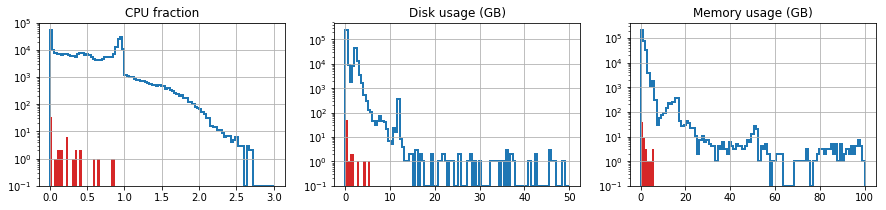

In [15]:
print("Avg cpu fraction for all condor jobs: {:.2f}").format(df_condor["fcpu"].mean())
print("Avg cpu fraction for bad condor jobs: {:.2f}").format(df_bad["fcpu"].mean())
print("")
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))
df_condor["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,histtype="step",lw=2)
df_bad["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,color="C3")
ax1.set_title("CPU fraction");

print("Avg disk usage for all condor jobs: {:.2f}GB").format(df_condor["diskGB"].mean())
print("Avg disk usage for bad condor jobs: {:.2f}GB").format(df_bad["diskGB"].mean())
print("")
df_condor["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,histtype="step",lw=2)
df_bad["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,color="C3")
ax2.set_title("Disk usage (GB)");

print("Avg memory usage for all condor jobs: {:.2f}GB").format(df_condor["memGB"].mean())
print("Avg memory usage for bad condor jobs: {:.2f}GB").format(df_bad["memGB"].mean())
print("")
df_condor["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,histtype="step",lw=2)
df_bad["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,color="C3")
ax3.set_title("Memory usage (GB)");

Apparently not. They're better than other condor jobs on average.

**But, what's going on in general with condor jobs that have >15GB memory usage?! Memory leaks?**

Take high memory usage jobs and separate by username

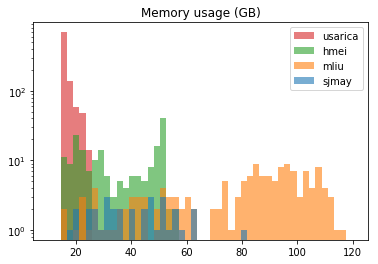

In [16]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["memGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["memGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,120.,50),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("Memory usage (GB)");

**And what about jobs with a CPU fraction > 1?**

Well, for some wiggle room, only check CPU fraction > 120%

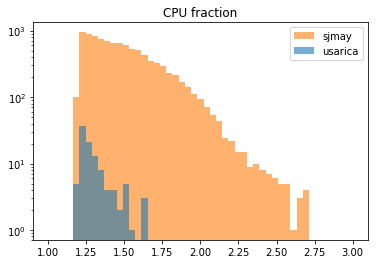

In [17]:
big = df_condor[df_condor["fcpu"]>1.2]
grouped = big.groupby("user")
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
vals = [grouped.get_group(user)["fcpu"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(1.0,3,50),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("CPU fraction");

**And jobs that use >15GB of disk?**
I suspect it's the rare foot-shooting where you write a root tree without clearing a vector branch every TTree::Fill()

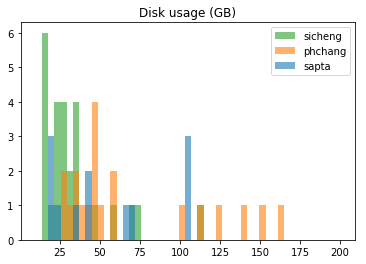

In [18]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["diskGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["diskGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,200.,50),label=users,histtype="stepfilled",alpha=0.6)
# ax.set_yscale("log")
ax.legend()
ax.set_title("Disk usage (GB)");

**Back to the candidate bad jobs. Who are they?**

No clear culprit, and if you submit more condor jobs, you're more likely to show up in the list by chance.

In [19]:
df_bad.groupby("user").size()

user
bemarsh    14
namin       4
phchang     4
sjmay      35
dtype: int64

In [20]:
fusers_bad = (df_bad.groupby("user").size()/len(df_bad))
fusers_all = (df_condor.groupby("user").size()/len(df_condor))
# Relative ratio of users in bad set wrt full set
(fusers_bad/fusers_all).dropna()

user
bemarsh    0.563096
namin      1.325724
phchang    6.594454
sjmay      3.407206
dtype: float64

**Actually, something I should have done at the beginning**
is check to see if certain hostnames are more prone to dropping hadoop nodes

(lost nodes might just be governed by bad hardware and not 100% strenuous user activity)

In [21]:
# Get 1D list of lost node hostnames
hosts = pd.Series(df_hadoop["hosts_lost"].map(list).values.sum())
print hosts

0     cabinet-0-0-17
1      cabinet-7-7-0
2     cabinet-4-4-25
3     cabinet-7-7-28
4      cabinet-7-7-9
5      cabinet-6-6-5
6      cabinet-7-7-4
7            sdsc-44
8     cabinet-7-7-28
9     cabinet-2-2-15
10    cabinet-7-7-26
11    cabinet-0-0-28
12     cabinet-8-8-2
13    cabinet-0-0-23
14    cabinet-7-7-28
15    cabinet-4-4-30
16    cabinet-4-4-31
17    cabinet-4-4-28
18    cabinet-4-4-29
19    cabinet-7-7-33
20    cabinet-7-7-23
21    cabinet-7-7-31
22    cabinet-7-7-25
23    cabinet-7-7-28
24    cabinet-4-4-29
25           sdsc-16
26     cabinet-7-7-5
27     cabinet-6-6-3
28    cabinet-7-7-22
29     cabinet-7-7-2
30     cabinet-2-2-2
31     cabinet-2-2-0
32     cabinet-7-7-2
dtype: object


Maybe the first two numbers give a physical location? Rack/whatever? 
So I'll ignore the 3rd for histogramming purposes. Also ignore those 2 lonely SDSC nodes.

In [22]:
# Pandas vectorized string operations are super neat
badbigcabinet = hosts[hosts.str.contains("cabinet")].str.rsplit("-",1).str[0]
# Fractions of "big cabinet" nodes (cabinet nodes grouped by first 2 numbers)
(badbigcabinet.value_counts()/len(badbigcabinet)).round(3)

cabinet-7-7    0.516
cabinet-4-4    0.194
cabinet-0-0    0.097
cabinet-2-2    0.097
cabinet-6-6    0.065
cabinet-8-8    0.032
dtype: float64

**Hmm. cabinet-7-7 is pretty popular.**

What about the distribution of nodes for all condor jobs?

In [23]:
allbigcabinet = df_condor.host[df_condor.host.str.contains("cabinet")].str.rsplit("-",1).str[0]
(allbigcabinet.value_counts()/len(allbigcabinet)).round(3)

cabinet-0-0      0.293
cabinet-5-5      0.215
cabinet-4-4      0.173
cabinet-11-11    0.096
cabinet-7-7      0.077
cabinet-1-1      0.048
cabinet-2-2      0.042
cabinet-8-8      0.035
cabinet-6-6      0.021
cabinet-3-3      0.001
Name: host, dtype: float64

**cabinet-7-7 is not so popular there.**

Taking the ratio, we see that it's 7x overrepresented in the bad set.

In [24]:
((badbigcabinet.value_counts()/len(badbigcabinet))/(allbigcabinet.value_counts()/len(allbigcabinet))).round(3).dropna()

cabinet-0-0    0.330
cabinet-2-2    2.331
cabinet-4-4    1.116
cabinet-6-6    3.117
cabinet-7-7    6.718
cabinet-8-8    0.931
dtype: float64